# Converting wind profiles to energy potential
Wind turbines convert the kinetic energy of the wind to electrical energy. The amount of energy produces thus depends on the wind speed, and the rotor area. If the wind speed is assumed to be uniform, then the calculation of the wind power is quite straightforward. However, if the vertical variability of the wind is taken into account, the power estimate is a bit different. In this document I will do some simple tests to assess the sensitivity of the wind power estimate to the wind speed and the method that is used to calculate it. 

## A conceptual figure

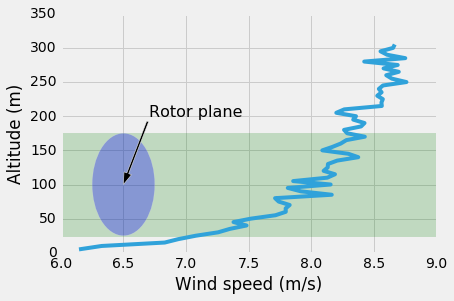

In [278]:
# Initialization
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
%matplotlib inline
plt.style.use('fivethirtyeight')

def logprofile(z,ust):
    ''' Return u as function of z(array) and u_star
        Uses Charnock relation for wind-wave interactions'''
    z0 = 0.011/9.81*ust # Charnock
    return ust/0.4*np.log(z/z0)

# Create artifical wind profile
ust = 0.25
z = np.arange(0,305,5)+5
u = logprofile(z,ust)+np.random.normal(0,.1,len(z))

# Create an ellipse that visualizes the rotor disk in the figure
rotor = Ellipse(xy=(6.5,100), width=.5, height=150, angle=0,alpha=.3)

# Create the figure
fig,ax = plt.subplots()
ax.plot(u,z)
ax.add_artist(rotor)
ax.annotate('Rotor plane',(6.5,100),(6.7,200),arrowprops=dict(facecolor='black',width=2,headwidth=8),fontsize=16)
ax.fill_between(ax.get_xlim(),175,25,color='g',alpha=.2)
ax.set_xlabel('Wind speed (m/s)')
ax.set_ylabel('Altitude (m)')
plt.show()

## Basic power estimate
The total kinetic energy of the mean flow that passes through the rotor plane in a given unit of time is equal to:

$$
E = ^1\!\!/_2 m u^2 = ^1\!\!/_2 \rho V u^2 = ^1\!\!/_2 \rho A u t u^2 = ^1\!\!/_2 \rho A t u^3
$$

Where $m$ is the mass of the air, $u$ the mean horizontal wind speed, $\rho$ is air density, and $V$ is the volume of the air passing through the rotor plane $A$ in time $t$. The power $P$ in the mean wind is equal to 

$$
P_{total} = ^E\!\!/t = ^1\!\!/_2 \rho A u^3
$$

and the fraction of it that is extracted by wind turbines and converted to electrical energy is

$$
P_{harvested} =  ^1\!\!/_2 \rho A u^3 c_p
$$

where $c_p$, the power coefficient of the turbine, is a sort of overall turbine efficiency. Since I'm mainly interested in the meteorological input and I will not discuss the value of $c_p$ and use the total power rather than the harvested power in the remainder.

Obviously, $A$ is determined by the rotor radius, which is assumed to be 75 m in the sketch above. Often, a constant wind speed at hub-height is used in first order estimates of $P$. In the sketch, the hub-height is 100 m, where $u\approx$ 8 m/s. If we assume a constant air density of 1.2 kg m$^{-1}$, the total power can be calculated easily as

$$
P_{total} = ^1\!\!/_2 \rho \pi R^2 u^3 \approx 5.4 \text{ MW}
$$



In [280]:
def power(rho,r,u):
    '''Return total wind power in MW as function of air density, rotor radius and wind speed at hub height'''
    return .5 * rho * np.pi * r**2 * u**3 / 1e6

r = 75.
u = 8.
rho = 1.2
print 'Power estimate: %.2f MW'%power(rho,r,u)

Power estimate: 5.43 MW


With this simple set-up it is easy to see that a small difference in wind speed translates to a large difference in wind energy:

In [281]:
for u in [7,8,9]:
    print 'Wind speed: %.1f m/s, wind power: %.2f MW'%(u,power(rho,r,u))

Wind speed: 7.0 m/s, wind power: 3.64 MW
Wind speed: 8.0 m/s, wind power: 5.43 MW
Wind speed: 9.0 m/s, wind power: 7.73 MW


and that an accurate estimate of $u_*$ is essential:

In [286]:
for ust in [.2,.25,.3]:
    u = logprofile(100,ust)
    p = power(rho,r,u)
    print 'u*: %.2f, wind speed: %.2f m/s, wind power: %.2f MW'%(ust,u,p)

u*: 0.20, wind speed: 6.50 m/s, wind power: 2.92 MW
u*: 0.25, wind speed: 7.99 m/s, wind power: 5.41 MW
u*: 0.30, wind speed: 9.45 m/s, wind power: 8.95 MW


## A more sophisticated approach
As can be seen from the figure above, a large difference in wind speed can occur between the top and the bottom of the rotor plane, and therefore a more realistic approach might give different results. 

The wind speed is a function of altitude. The area of the rotor plane can also be expressed as a function of altitude, namely by integrating the width of the rotor plane with respect to $z$:

$$
A = \int_{h-r}^{h+r} 2x(z) dz
$$

Here, $h$ is the hub height of the wind turbine, $r$ is the rotor radius, and $x(z)$ is the horizontal distance from the edges of the rotor plane to the vertical axis. An expression for $x(z)$ is given below:

$$
x(z) = \sqrt{r^2-(z-h)^2}
$$

If $z-h$ becomes larger than $r$ in the formula above, then the square root will not have real solutions. Thus, $x(z)$ is only defined in the rotor plane and it is set to 0 at all other altitudes. To find the estimated wind power, we evaluate the following summation:

$$
\sum_z \rho x(z)u(z)^3 \Delta z
$$



In [275]:
# Vertical levels
dz = 1
z = np.arange(0,300+dz,dz)+dz

# Turbine characteristics
r = 75 # rotor radius
h = 100 # hub height
x = np.where(np.abs(z-h)<r,np.sqrt(r**2-(z-h)**2),0) # the error is only due to the construction of `np.where`

# Logprofile
ust = 0.25
u = logprofile(z,ust)+np.random.normal(0,.1,len(z))

# Energy
rho = 1.2
es = sum(u**3*x)*rho*dz*1e-6 #sophisticated method
eb = .5 * rho * np.pi * r**2 * u[h]**3 / 1e6 #basic method

print 'Wind power with basic formula: %.2f MW'%eb
print 'Wind power with sophicsticated formula: %.2f MW'%es
print 'Difference: %.2f MW'%(es-eb)

Wind power with basic formula: 5.49 MW
Wind power with sophicsticated formula: 5.30 MW
Difference: -0.19 MW


/home/peter/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in sqrt


## A simple uncertainty analysis
Below I will create 10000 randomly disturbed wind profiles, and perform the two power calculations for all these wind profiles. With this, I can make an estimate of the uncertainty in the power calculation that results from the uncertainty in the wind. Moreover, by comparing the two power estimates, I can compute some statistics on the error that is introduced by neglecting the vertical variability of the wind.

In [276]:
# Vertical levels
dz = 1
z = np.arange(0,300+dz,dz)+dz

# Turbine characteristics
r = 75 # rotor radius
h = 100 # hub height
x = np.where(np.abs(z-h)<r,np.sqrt(r**2-(z-h)**2),0) # the error is only due to the construction of `np.where`

# Store the output in these lists:
output_basic = []
output_sophisticated = []

# Perform 10000 load calculations
for i in range(10000):
    # Logprofile
    ust = 0.25
    u = logprofile(z,ust)+np.random.normal(0,.1,len(z))

    # Energy
    rho = 1.2
    es = sum(u**3*x)*rho*dz*1e-6
    output_sophisticated.append(es)
    
    eb = .5 * rho * np.pi * r**2 * u[h]**3 / 1e6
    output_basic.append(eb)
    
# Some statistics
output_sophisticated = np.asarray(output_sophisticated)
print 'Sophisticated method:'
print 'Mean power: %.2f MW'%output_sophisticated.mean()
print 'Standard deviation: %.4f MW'%output_sophisticated.std()

output_basic = np.asarray(output_basic)
print '\nBasic method:'
print 'Mean power: %.2f MW'%output_basic.mean()
print 'Standard deviation: %.4f MW'%output_basic.std()

errors = output_basic-output_sophisticated
print '\nError statistics:'
print 'Mean absolute error: %.2f MW'%(np.mean(np.abs(errors)))
print 'Root mean squar error: %.2f MW' %(np.sqrt(np.mean(errors*errors)))

/home/peter/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in sqrt


Sophisticated method:
Mean power: 5.32 MW
Standard deviation: 0.0170 MW

Basic method:
Mean power: 5.42 MW
Standard deviation: 0.2057 MW

Error statistics:
Mean absolute error: 0.18 MW
Root mean squar error: 0.23 MW


From this quick analysis we can deduce that an uncertainty of 0.1 m/s in the observed wind results in an uncertainty of 17 KW (0.32%) in wind power for a sample wind turbine when using the sophisticated method. Using the basic method gives an uncertainty of about 200 KW (3.7%), but also it results in an error of about 200 KW when tested against the more sophisticated method.